In [11]:
import numpy as np
import os
import laspy
import tkinter as tk
from numba import njit
import tkinter.filedialog
import scipy
import scipy.ndimage
import scipy.spatial
%gui tk
# create a gui to let user select the working folder
root=tk.Tk()
working_folder = tkinter.filedialog.askdirectory(parent=root,title='Please select a directory')
root.destroy() # close the gui after user selects the input 
print(working_folder)

In [12]:
os.chdir(working_folder)
vlp32=laspy.read('20201002_VLP32C_ICSC.las') # read point cloud from VLP32C
riegl=laspy.read('20200827_Riegl_Calib.las') # read point cloud from riegl


In [3]:

def type_converter(las):
    las_x=np.array(las.x) # get coordinates x
    las_y=np.array(las.y) # get coordinates y
    las_z=np.array(las.z) # get coordinates z
    return [las_x,las_y,las_z]
# Estimate Point Density
@njit()
def point_density_estimator(grid_size,las_xyz):
    '''
    This function is vectorized
    '''
    [las_x,las_y,las_z]=las_xyz
    # defome area of interest
    x_max=np.max(las_x)
    x_min=np.min(las_x)
    y_max=np.max(las_y)
    y_min=np.min(las_y)
    col_max=int((x_max-x_min)/grid_size) # compute number of col
    row_max=int((y_max-y_min)/grid_size) # compute number of row
    density_map=np.full((row_max,col_max),-1.0) # create a placeholder for density map
    height_90p=np.full((row_max,col_max),-1.0) # create a placeholder for 90% height
    for row in range(row_max):
        y_top=y_max-row*grid_size # compute the upper bound of the grid
        y_bot=y_max-(row+1)*grid_size # compute the lower bound of the grid
        # determine the boolen value (whether a point is inside upper bound and lower bound)
        index_y=np.logical_and(las_y>=y_bot,las_y<y_top) 
        # The following 2 lines extract points within y_top and y_bot
        pc_xtemp=las_x[index_y] 
        pc_ztemp=las_z[index_y]
        for col in range(col_max):
            index_x=None
            x_left=x_min+grid_size*col # determine the left bound 
            x_right=x_min+grid_size*(col+1) # determine the right bound
            # determine the boolen value (whether a point is inside left bound and right bound)
            index_x=np.logical_and(pc_xtemp>x_left,pc_xtemp<x_right) 
            n_points=np.sum(index_x) # compute number of points inside the grid
            # density_map[row,col]=n_points/(grid_size**2) # compute LPD
            density_map[row,col]=n_points
            pc_z_in_grid=pc_ztemp[index_x] # z coordinates of points in the grid
            if len(pc_z_in_grid)>0:
                height_90p[row,col]=np.percentile(pc_z_in_grid,90) # compute 90% height inside the grid
        index_y=None
    return density_map, height_90p
def DSM_generation(height_90p,window_size):
    # fill the gap with a window
    height_90p[height_90p==-1]=np.nan # set nan value
    # Apply nanmean filter on the whole image as an independent array 
    correction_array=scipy.ndimage.generic_filter(height_90p,function=np.nanmean,size=(window_size,window_size))
    # if a value in 90p height is nan, use the pixel value from correction_array 
    height_90p[height_90p==np.nan]=correction_array[height_90p==np.nan]

    # Mediam filter ignoring nan value
    dsm=scipy.ndimage.generic_filter(height_90p,function=np.nanmedian,size=(3,3))
    return dsm
    

In [39]:
density_map_vlp32_05,height_90p_vlp32_05=point_density_estimator(0.5,type_converter(vlp32))
density_map_riegl_05,height_90p_riegl_05=point_density_estimator(0.5,type_converter(riegl))
density_map_riegl_01,height_90p_riegl_01=point_density_estimator(0.1,type_converter(riegl))
density_map_vlp32_01,height_90p_vlp32_01=point_density_estimator(0.1,type_converter(vlp32))


E:\Ender\code\envv\ggdal\lib\site-packages\numba\core\ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'las_xyz' of function 'point_density_estimator'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-38-e179fb1f7a77>", line 8:
@njit()
def point_density_estimator(grid_size,las_xyz):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


In [40]:
DSM_riegl_05=DSM_generation(height_90p_riegl_05,1)
DSM_riegl_01=DSM_generation(height_90p_riegl_01,1)
DSM_vlp32_05=DSM_generation(height_90p_vlp32_05,1)
DSM_vlp32_01=DSM_generation(height_90p_vlp32_01,1)

E:\Ender\code\envv\ggdal\lib\site-packages\scipy\ndimage\filters.py:1601: RuntimeWarning: Mean of empty slice
  _nd_image.generic_filter(input, function, footprint, output, mode,
E:\Ender\code\envv\ggdal\lib\numpy\lib\nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [23]:
# Visualize the map
import matplotlib.pyplot as plt
def ez_plot(raster,title):
    # plt.imshow(raster,cmap='rainbow',vmax=np.nanpercentile(raster,99),vmin=np.nanpercentile(raster,1)) # create picture
    plt.imshow(raster,cmap='rainbow',vmax=np.nanpercentile(raster,99)) # create picture
    plt.colorbar() # show color bar
    plt.title(title)# show title
    plt.savefig(fname=f'E:/Ender/coursework/Laser Scanning/hw2/{title}.png',dpi=500) # save figure
    plt.show()



In [41]:
density_map_vlp32_05[density_map_vlp32_05==0]=np.nan
density_map_vlp32_01[density_map_vlp32_01==0]=np.nan
density_map_riegl_05[density_map_riegl_05==0]=np.nan
density_map_riegl_01[density_map_riegl_01==0]=np.nan

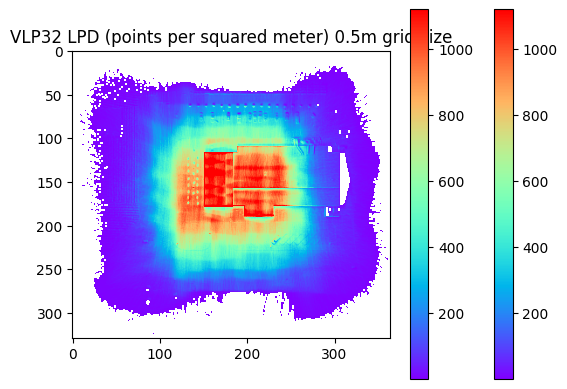

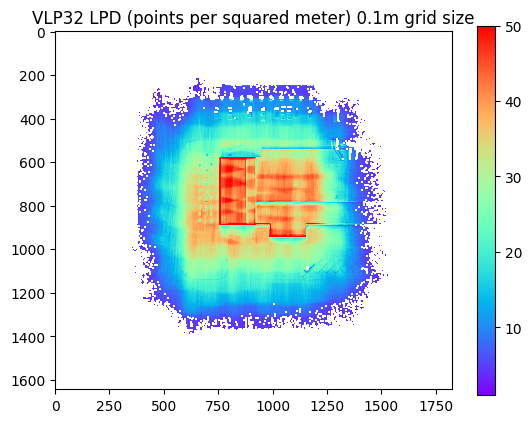

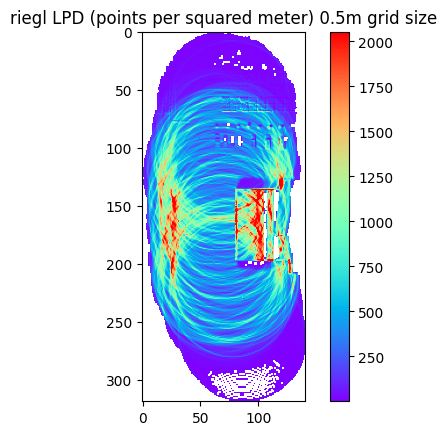

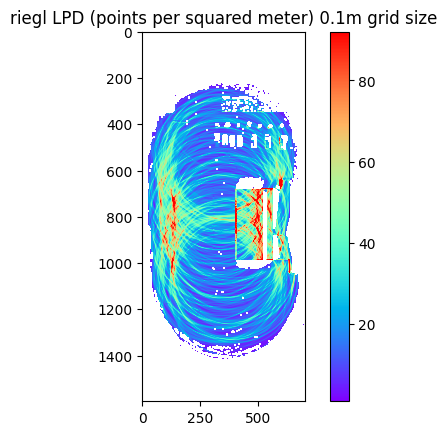

In [53]:
ez_plot(density_map_vlp32_05,'VLP32 LPD (points per squared meter) 0.5m grid size')
ez_plot(density_map_vlp32_01,'VLP32 LPD (points per squared meter) 0.1m grid size')
ez_plot(density_map_riegl_05,'riegl LPD (points per squared meter) 0.5m grid size')
ez_plot(density_map_riegl_01,'riegl LPD (points per squared meter) 0.1m grid size')

In [ ]:

ez_plot(DSM_vlp32_05,'VLP32 DSM 0.5m grid size')
ez_plot(DSM_vlp32_01,'VLP32 DSM 0.1m grid size')
ez_plot(DSM_riegl_05,'riegl DSM 0.5m grid size')
ez_plot(DSM_riegl_01,'riegl DSM 0.1m grid size')

# Task 3

In [13]:
def points_convertor(las):
    '''
    This function make the array look like [[x1,y1,z1],[x2,y2,z2]...]
    '''
    points=np.vstack((las.x,las.y,las.z)).transpose()
    return points


In [14]:
from numpy.linalg import eig
@njit()
def pca_V(nn_points,M):
    '''
    This function is vectorized
    '''
    # Compute point coordinates - centroid
    C=nn_points-M
    V=np.cov(C.T) # compute covariance
    eigenValues, vectors=eig(V) # compute eigen value
    # sort the eigen value
    idx = eigenValues.argsort()[::-1]  
    eigenValues = eigenValues[idx]
    # determine lambda
    lambda1=eigenValues[0]
    lambda2=eigenValues[1]
    lambda3=eigenValues[2]
    # compute a1 a2 a3
    a1=(np.sqrt(lambda1)-np.sqrt(lambda2))/np.sqrt(lambda1)
    a2=(np.sqrt(lambda2)-np.sqrt(lambda3))/np.sqrt(lambda1)
    a3=np.sqrt(lambda3)/np.sqrt(lambda1)
    a=np.array([a1,a2,a3])
    return a
def pca(nn_points):
    M=np.mean(nn_points.T, axis=1) # compute centroid
    return pca_V(nn_points,M)



In [15]:
def classification_100(las):
    k=100 # define k
    points=points_convertor(las) # change the shape of the array
    tree=scipy.spatial.cKDTree(points) # build KD tree
    nn_sets=tree.query(points,k) # query KNN points
    classes=np.zeros(points.shape[0]) # create place holder for classification result
    for i in range(nn_sets[1].shape[0]):
        # subset the KNN points
        nn_points_index=nn_sets[1][i]
        nn_points=points[nn_points_index]
        a=pca(nn_points) # comptue PCA
        classes[i]=np.argmax(a)+1 # do classification
    return classes
def classification_1000(las):        
    k=1000 # define k
    points=points_convertor(las) # change the shape of the array
    classes=np.zeros(points.shape[0]) # create place holder for classification result
    tree=scipy.spatial.cKDTree(points)# build KD tree
    patch_size=int(points.shape[0]/3) # define patch size for iterating the process
    nn_sets=tree.query(points[0:patch_size],k) # query KNN for the patch
    for i in range(0, patch_size):
        # subset the KNN points
        nn_points_index=nn_sets[1][i] 
        nn_points=points[nn_points_index]
        a=pca(nn_points) # compute PCA
        classes[i]=np.argmax(a)+1 # classifying the result
    '''
    The following codes simply repeat the process
    '''
    nn_sets=tree.query(points[patch_size:patch_size*2],k)
    for i in range(patch_size, patch_size*2):
        nn_points_index=nn_sets[1][i]
        nn_points=points[nn_points_index]
        a=pca(nn_points)
        classes[i]=np.argmax(a)+1
    nn_sets=tree.query(points[patch_size*2:points.shape[0]],k)
    for i in range(patch_size*2, points.shape[0]):
        nn_points_index=nn_sets[1][i]
        nn_points=points[nn_points_index]
        a=pca(nn_points)
        classes[i]=np.argmax(a)+1
    return classes 




In [19]:
riegl_class_100=classification_100(riegl)
vlp32_class_100=classification_100(vlp32)
riegl_class_1000=classification_1000(riegl)
vlp32_class_1000=classification_1000(vlp32)

In [20]:
def save_pc(las,classes,fname):
    las_new=laspy.create(point_format=las.header.point_format,file_version=las.header.version)
    las_new.x=las.x
    las_new.y=las.y
    las_new.z=las.z
    las_new.classification=classes
    las_new.write(fname)
# save_pc(riegl,riegl_class_100,'riegl_1002.las')
save_pc(riegl,riegl_class_100,'riegl_100.las')
save_pc(riegl,riegl_class_1000,'riegl_1000.las')
save_pc(vlp32,vlp32_class_100,'vlp32_100.las')
save_pc(vlp32,vlp32_class_1000,'vlp32_1000.las')

In [11]:
np.max(riegl_1000_class)

0.0